In [1]:
from chainer import links as L
import chainer.functions as F
import chainer
from chainer import Chain, Link
from chainer import Parameter
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable, optimizers
import numpy as np
import PIL.Image
from io import BytesIO

mean = [103.939, 116.779, 123.68]
#  modelVGG = VGG16Layers()

In [2]:
# 基本入出力関数
# Add 
def add_mean(blob,mean):
    x = blob.copy()
    x[0,0,:,:] += mean[0]
    x[0,1,:,:] += mean[1]
    x[0,2,:,:] += mean[2]
    return x

# 配列の表示
def showarray(a, fmt='jpeg'):  # numpy 配列としての画像を表示
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# blob データを PIL 画像に変換
def blob2img(blob):
    blob = np.dstack(blob[0])[:,:,::-1]
    return PIL.Image.fromarray(np.uint8(blob))

# blob データを画像として保存
def save_image(blobimg, it):
    def clip(a):
        return 0 if a<0 else (255 if a>255 else a)
    blobimg = np.vectorize(clip)(blobimg)
    image = blob2img(blobimg)
    image.save("frames/im_%05d.png"%it)
    return image

# チャネル間の相関行列
def ch_corr_matrix(ld):
    # 0次元目はバッチ数
    ch = ld.shape[1] # チャネル数
    size = ld[0][0].size  # チャネルあたりのデータ数
    cmatrix = F.reshape(ld, (ch,size)) # チャネルごとに１次元化した ch x size の配列を作る
    matrix = F.matmul(cmatrix, cmatrix,transb=True) / np.float32(size) # 相関行列
    return matrix

In [164]:
# layers_for_orig = ["conv4_1", "conv4_2", "conv4_3", "vpool4"]
# layers_for_style =["conv1_1", "conv1_2", "pool1", "conv2_1", "conv2_2", "pool2", "conv3_1", "conv3_2", "conv3_3v3","pool3"]

lr = np.float32(4.0) # 学習係数
rr = np.float32(0.005) # 元画像/スタイル画像 比率
width = 224
imgsize = (1,3,224,224)
iter = 5000  # 繰り返し回数


# from chainer import links as L
# from chainer import links as L
class Painter(Chain):
    def __init__(self,n_image, n_style):
        super(Painter, self).__init__(
            picture=L.Linear(None, (1,3,width,width)),
            model = L.VGG16Layers())
        generatedpics = np.random.uniform(-20,20,3*width*width).astype(np.float32)
        self.picture.data = generatedpics
        self(n_image,stage=1)
        self(n_style,stage=2)
        self(self.picture,stage=0)
        self.make_optimizer() 
        
        
    def __call__(self, img=None, stage = 0,  stages=['pool2','pool3']):
        if stage==1 :  # 対象画像の特徴を得る
            with chainer.no_backprop_mode():
                h = self.model.extract([img],layers=['pool3'])
                h = h['pool3']
                self.feature3 = h
                return h
        elif stage == 2: # スタイル画像の特徴を得る
            with chainer.no_backprop_mode():
                h = self.model.extract([img],layers=['pool2'])
                h = h['pool2']
                self.feature2 = h
                return h
        else :
                x = self.picture.data.reshape(3,width,width)
                h = self.model.extract([x],stages)
                #  showarray([x])
                return h
        
    def make_optimizer(self):
        self.optimizer = optimizers.Adam(alpha=2e-4, beta1=0.5)
        self.optimizer.setup(self.picture) 
        return 
    
    def update(self, st1=['pool3'], st2=['pool2']):
        self.L= Variable(np.zeros(1, dtype=np.float32))
        self.L1= Variable(np.zeros(1, dtype=np.float32))
        self.L2= Variable(np.zeros(1, dtype=np.float32))
        
        self.h = self(None, stage=0)
        self.h2 = self.h['pool2'] # 
        self.h3 = self.h['pool3']
        self.f2 = self.feature2
        self.f3 = self.feature3
        self.cormatrixh2 = ch_corr_matrix(self.h2)
        self.cormatrixf2 = ch_corr_matrix(self.f2)

        print(rr * lr*F.mean_squared_error(self.h3, self.f3))
        
        self.L1 += Variable(np.array([rr * lr*F.mean_squared_error(self.h3, self.f3).data]))        
        self.L2 += Variable(np.array([(F.mean_squared_error(self.cormatrixh2, self.cormatrixf2)/np.float32(len(self.cormatrixf2))).data]))
        self.L = self.L1 + self.L2
        self.L.backward()
        self.optimizer.update()
        return self.L


In [175]:
nn.picture.zerograds() 
nn.L=nn.L1+nn.L2
nn.L.backward()

In [185]:
nn.picture.ggg = 1
nn.picture.data

array([-10.66240692, -14.06484032, -13.77671242, ..., -16.67713928,
        15.1726017 ,  -8.52230167], dtype=float32)

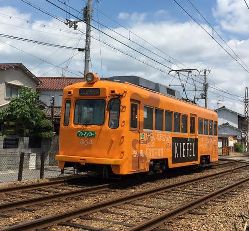

In [4]:
img = PIL.Image.open("train.jpg")
nimg = VGGprepare(img)
img.resize(np.array(img.size)//2)  # 画像の確認（ハーフサイスで表示している）

In [165]:
nn = Painter(nimg,nimg)

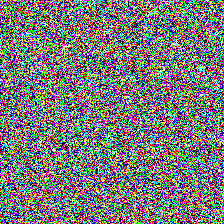

In [6]:
blob2img(nn.picture.data.reshape(1,3,224,224))


In [149]:
Variable(np.array([rr * lr*F.mean_squared_error(nn.h3, nn.f3).data]))

variable([ 35078.01171875])

In [67]:
print(rr * lr*F.mean_squared_error(nn.h3, nn.f3))

variable(34824.8671875)


In [103]:
c =Variable(np.array([[3,4]]).astype(np.float32))


In [104]:
b = F.mean_squared_error(2*a,c)

In [124]:
Variable(np.array(rr * lr*F.mean_squared_error(nn.h3, nn.f3).data))

variable(34763.1796875)

In [106]:
b.backward()

In [108]:
c.grad

array([[-3., -2.]], dtype=float32)

In [163]:
Variable(np.array([rr * lr*F.mean_squared_error(nn.h3, nn.f3).data]))

variable([ 34948.72265625])

In [166]:
nn.update()

variable(35177.6953125)


variable([  9.76271360e+09])

In [ ]:
y =x + 4

In [ ]:
y.backward()

In [ ]:
x.grad

In [ ]:
x

In [192]:
x = np.arange(1 * 1 *3* 4, dtype='f').reshape(1,1, 3, 4)

In [ ]:
c=np.array([4])

In [199]:
l = L.Convolution2D(1, 2, 2)

In [200]:
y = l(x)

In [202]:
x

array([[[[  0.,   1.,   2.,   3.],
         [  4.,   5.,   6.,   7.],
         [  8.,   9.,  10.,  11.]]]], dtype=float32)

In [203]:
y.shape

(1, 2, 2, 3)

In [ ]:
e

In [ ]:
e.backward()

In [ ]:
nn.L2.grad

In [ ]:
nn.L = nn.L1 + nn.L2

In [ ]:
nn.L1 = nn.L

In [ ]:
nn.L1.backward()

In [ ]:
nn.L.grad